In [ ]:

%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [ ]:
df = pd.read_csv("../input/nlp-coursework/1613373921-5e748a2d5fc288e9f69c5f86.csv")

In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
df['none'] = 1-df[label_cols].max(axis=1)
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405
6,none,143346


Text(0.5, 0, 'category')

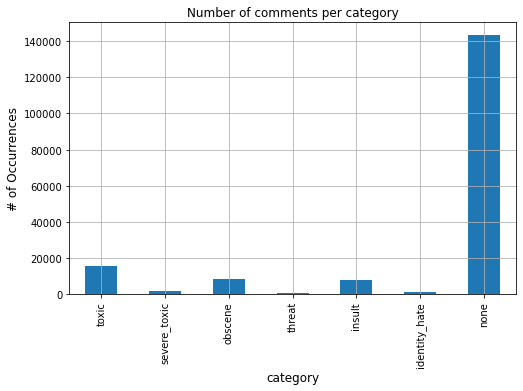

In [ ]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# of categories')

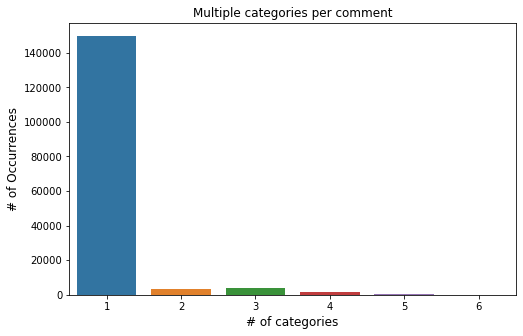

In [ ]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

<AxesSubplot:>

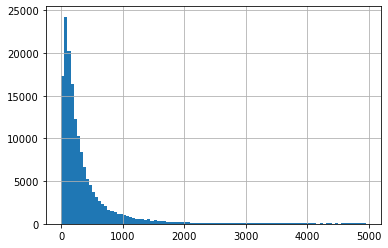

In [ ]:
lens = df.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

In [ ]:
print('Number of missing comments in comment text:')
df['comment_text'].isnull().sum()

Number of missing comments in comment text:


0

In [ ]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','none']

In [ ]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

In [ ]:
df['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

In [ ]:
train, test = train_test_split(df, random_state=42, test_size=0.20, shuffle=True)

In [ ]:
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(127656,)
(31915,)


In [ ]:
print(X_train)

140030    grandma terri should burn in trash grandma ter...
159124    9 may 2009 utc it would be easiest if you were...
60006     the objectivity of this discussion is doubtful...
65432                          shelly shock shelly shock is
154979    i do not care refer to ong teng cheong talk pa...
                                ...                        
119879    redirect talk john loveday experimental physicist
103694     back it up post the line here with the reference
131932    i wo not stop that sometimes germanic equals g...
146867    british bands i think you have mistaken scotti...
121958    you are wrong justin thompson is mentioned in ...
Name: comment_text, Length: 127656, dtype: object


In [ ]:
y_train = train.drop(['id', 'comment_text'], axis=1)
#y_train.columns = [''] * len(y_train.columns)
y_test = test.drop(['id', 'comment_text'], axis=1)
print(y_train)

        toxic  severe_toxic  obscene  threat  insult  identity_hate  none
140030      1             0        0       0       0              0     0
159124      0             0        0       0       0              0     1
60006       0             0        0       0       0              0     1
65432       0             0        0       0       0              0     1
154979      0             0        0       0       0              0     1
...       ...           ...      ...     ...     ...            ...   ...
119879      0             0        0       0       0              0     1
103694      0             0        0       0       0              0     1
131932      1             0        0       0       0              0     0
146867      0             0        0       0       0              0     1
121958      0             0        0       0       0              0     1

[127656 rows x 7 columns]


In [ ]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None, alpha=1e-3))),
            ])

In [ ]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None, alpha=1e-3))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    
    
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9434435218549272
... Processing severe_toxic
Test accuracy is 0.9893153689487701
... Processing obscene
Test accuracy is 0.9671001096663011
... Processing threat
Test accuracy is 0.9975246749177503
... Processing insult
Test accuracy is 0.9639041203195989
... Processing identity_hate
Test accuracy is 0.9898167006109979
... Processing none
Test accuracy is 0.9417515274949083


In [ ]:

SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

In [ ]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9602694657684474
... Processing severe_toxic
Test accuracy is 0.9906626977910074
... Processing obscene
Test accuracy is 0.9794454018486605
... Processing threat
Test accuracy is 0.9976813410621964
... Processing insult
Test accuracy is 0.9711107629641235
... Processing identity_hate
Test accuracy is 0.9920726930910231
... Processing none
Test accuracy is 0.9606767977440075


In [ ]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag', C=7), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9601127996240012
... Processing severe_toxic
Test accuracy is 0.9907253642487859
... Processing obscene
Test accuracy is 0.9791947360175466
... Processing threat
Test accuracy is 0.9976500078333073
... Processing insult
Test accuracy is 0.9708600971330096
... Processing identity_hate
Test accuracy is 0.9918846937176876
... Processing none
Test accuracy is 0.9603007989973367


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RanFor_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(RandomForestClassifier(max_depth= 15, n_estimators=40), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    RanFor_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = RanFor_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9042456525144916
... Processing severe_toxic
Test accuracy is 0.989942033526555
... Processing obscene
Test accuracy is 0.9462635124549584
... Processing threat
Test accuracy is 0.9976813410621964
... Processing insult
Test accuracy is 0.9494281685727715
... Processing identity_hate
Test accuracy is 0.9907880307065643
... Processing none
Test accuracy is 0.8983863387122043


In [ ]:
DecTree_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(DecisionTreeClassifier(max_depth = 25), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    DecTree_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = DecTree_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9460128466238445
... Processing severe_toxic
Test accuracy is 0.9884380385398716
... Processing obscene
Test accuracy is 0.9772834090553032
... Processing threat
Test accuracy is 0.9973053423155256
... Processing insult
Test accuracy is 0.9652827823907254
... Processing identity_hate
Test accuracy is 0.991665361115463
... Processing none
Test accuracy is 0.944477518408272
